# Spam Email Classifier

This notebook will contain all research work for the common classification problem of determining whether a given email is spam or not. This is mainly to demonstrate my skills in exploratory data analysis, feature engineering, feature selection, and modelling. For the purposes of interpretability, we will mainly focus on using logistic regression as a means of classification. Outside of this notebook, I hope to demonstrate skills in developing a good pipeline to deploy such a classifier.

### Why is this important?
We are inundated with emails almost constantly, with some being important, and countless others being spam. Thus, we want to build an automatic classifier that throws away spam email, but keeps the important emails for us to see. This will save us a lot time from having to sift through a lot of junk emails.

### Model Objective
Our model should obviously have a high accuracy, but to be safe, we prefer a low false positive rate so that no one misses actual important emails. Thus, we also wish to have a high area under the ROC curve score.

### The Data
We have two csv files already downloaded. They each contain data that are structured with four attributes:

- `id`: The ID of the sample email data
- `subject`: The subject of the email
- `email`: The text of the email itself
- `spam`: 1 if the email is spam, 0 if not

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [4]:
raw_training = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Lower-case all the text in the emails
raw_training['email'] = raw_training['email'].str.lower()
test['email'] = test['email'].str.lower()

raw_training.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


## Data Cleaning and Exploratory Analysis

Let's take some time to simply clean the data by removing missing values, but note that there is not much necessary cleaning to do. We will replace any missing values with an empty string, as there is not much else to do with text data. The data is raw email text, so we have more work to do when processing the data before prediction. For feature engineering and selection, we will definitely have to look into the data to create meaningful features.

In [5]:
raw_training = raw_training.fillna("")

Let us now take a look at emails that are both spam and not spam to look for any differences.

In [6]:
reg_example = raw_training[raw_training['spam'] == 0]['email'].iloc[0]
spam_example = raw_training[raw_training['spam'] == 1]['email'].iloc[0]
print(reg_example)
print(spam_example)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



The first thing to notice is that the subject (i.e., content) of the emails is the most strikingly different aspect between the spam and regular emails. Furthermore, we see that spam emails are more likely to contain many links that consist of seemingly random strings of characters, as opposed to just a few links in regular emails. We will also have to look into the fact that the spam email example is given as HTML. One thing that is easy in differentiating between spam and non-spam is the existence of a greeting or farewell with a name. For example, the first regular email exam has "thanks, misha" while there is no such thing for the spam email.


Let us split our data into a training set and validation set. Then, we will perform more exploratory analysis and feature engineering. Furthermore, we will have to transform our text data into quantitative features in order to perform classification through machine learning.

In [9]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(raw_training, test_size=0.1, random_state=0)
train.head()

,id,subject,email,spam
5739,5739,Subject: Toners and inkjet cartridges for less...,"<hr>\n <html>\n <div bgcolor=3d""#ffffcc"">\n \n...",1
4121,4121,Subject: Re: the underground software vulnerab...,"hi kragen,\n \n this is an interesting anal...",0
7783,7783,Subject: Re: [Razor-users] Re: What's wrong wi...,"justification could be ""this user has a great ...",0
1035,1035,Subject: The subtle art of sugaring bitter pil...,"url: http://www.newsisfree.com/click/-3,845608...",0
4563,4563,Subject: Re: The GOv gets tough on Net Users.....,">>>>> ""m"" == mike masnick <mike@techdirt.com> ...",0


In [10]:
# A function that takes in a list of words, and for each email in our data, returns an indicator
# list: for each word in the list, mark 1 if that word appears in that email, and 0 otherwise.
def words_emails(words, emails):
    # words: list of words to find in emails
    # emails: list of email texts
    indicator_array = np.array([emails.str.contains(w) for w in words]).transpose().astype(int)
    return indicator_array

This function allows us to take a look at which words efficiently "determine" the spam class and non-spam class. By this we mean, which words are substantially more prevalent in spam emails vs. non-spam emails. Below is a list of words that are indeed relatively good indicators of spam emails. Note that we use "opportunit," "remov," and "receiv" to capture different spelling-changes when considering different suffixes to the root words. Note that "href" is used primarily in HTML files.

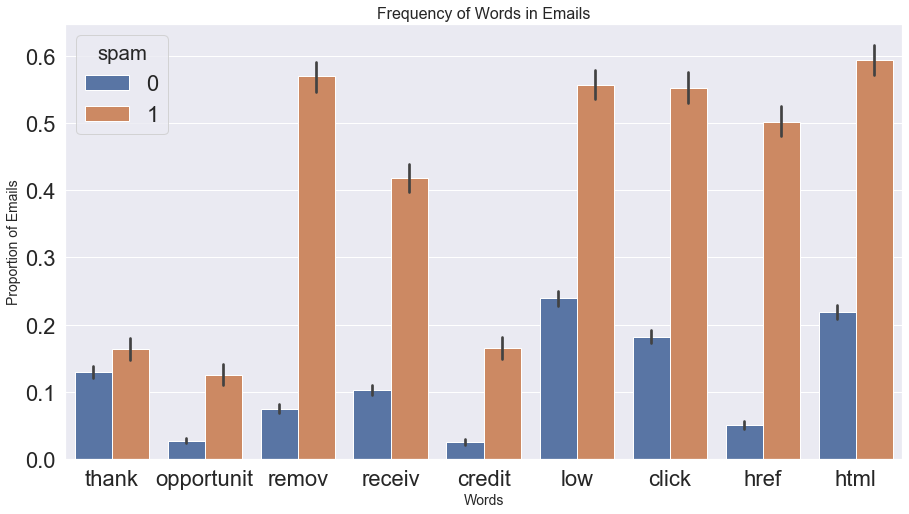

In [20]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_emails

train_words = train.reset_index(drop=True)
train_words = train_words.drop(["id", "subject"], axis=1)

words = ["opportunit", "remov", "receiv", "credit", "low", "click", "href", "html"]

train_words[words] = pd.DataFrame(words_emails(words, train_words["email"]))
train_words = train_words.melt(["spam", "email"])

plt.figure(figsize=(15,8))
sns.set(font_scale = 2)
sns.barplot(x="variable", y="value", hue="spam", data=train_words)
plt.title("Frequency of Words in Emails", fontsize=16)
plt.ylabel("Proportion of Emails", fontsize=14)
plt.xlabel("Words", fontsize=14)
plt.show()

Let's now take a look a some other quantitative variables. Below is a class-conditional density plot of the distribution of the lengths of spam emails vs. the lengths of non-spam emails, by number of characters. 

We see a clear and striking difference in the distributions: spam emails tend to have fewer characters total than non-spam emails. In fact, the distribution of length among non-spam emails almost looks uniform compared to the distribution for spam emails, which has a huge spike around 2000-4000 characters.

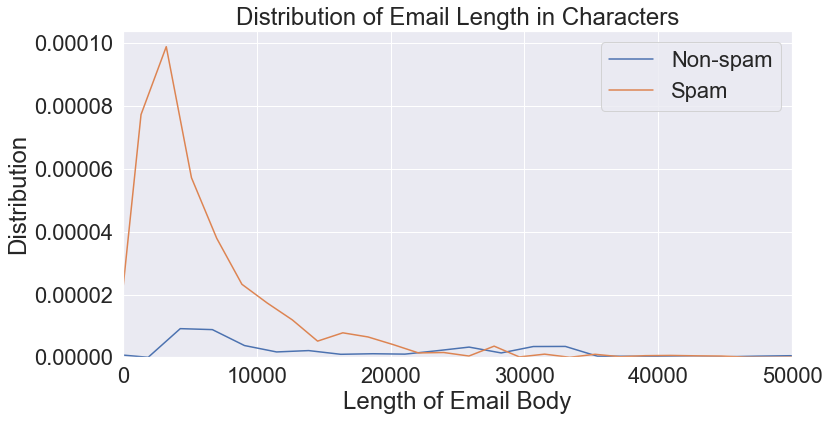

In [23]:
plt.figure(figsize=(12, 6))
ham = sns.distplot(train[train['spam'] == 0]['email'].str.len().values, hist=False, label="Non-spam")
spam = sns.distplot(train[train['spam'] == 1]['email'].str.len().values, hist=False, label="Spam")
plt.xlabel("Length of Email Body")
plt.ylabel("Distribution")
plt.title("Distribution of Email Length in Characters")
plt.xlim((0, 50000))
plt.show()